In [1]:
# ============================================================================
# IMPORTS
# ============================================================================
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.cross_decomposition import CCA
import umap

# Suppress UMAP warnings (with a set random state)
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

plt.rcdefaults()

# 1. Load Data
For a given run, we load all trials and "preprocess" them for analysis.

In [2]:
RUNS_PATH = Path("./runs/ab_manifold/")
TRIAL_PATH = "20251219-121335_ab_large"

FRACTION = 0.2  # Proportion of units to keep in each region for sub-sampling analysis

def stage_to_phase(stage: str) -> str:
    """
    Map experimental stage to high-level phase.
    
    Args:
        stage: Stage identifier from the experiment.
        
    Returns:
        Phase category: "independent", "A_to_B", "B_to_A", or "other".
    """
    if stage == "init_pair" or stage.startswith("stabilize_"):
        return "independent"
    if stage == "seed_A_to_B" or stage.startswith("A_to_B_recur_"):
        return "A_to_B"
    if stage == "seed_B_to_A" or stage.startswith("B_to_A_recur_"):
        return "B_to_A"
    return "other"

def sample_neurons(
    region_activity: np.ndarray,
    n_neurons: int | None = None,
    fraction: float | None = None,
    random_state: int = 0,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Randomly subsample neurons from a region's activity.
    
    Args:
        region_activity: Activity matrix of shape (time, neurons).
        n_neurons: Exact number of neurons to sample. Takes precedence over fraction.
        fraction: Fraction of total neurons to sample (default 0.5 if neither specified).
        random_state: Seed for reproducibility.
        
    Returns:
        Tuple of (subsampled_activity, selected_indices).
    """
    rng = np.random.default_rng(random_state)
    T, n_total = region_activity.shape
    
    if n_neurons is not None:
        n_to_sample = min(n_neurons, n_total)
    elif fraction is not None:
        n_to_sample = max(1, int(np.round(fraction * n_total)))
    else:
        n_to_sample = max(1, int(np.round(0.5 * n_total)))
    
    idx = np.sort(rng.choice(n_total, size=n_to_sample, replace=False))
    return region_activity[:, idx], idx

def process_trial(trial_file: Path, fraction: float) -> dict:
    """
    Load and preprocess a single trial.
    
    Extracts activity data, converts stages to phases, filters by phase,
    and creates subsampled versions.
    
    Args:
        trial_file: Path to the trial .npz file.
        fraction: Fraction of neurons to retain in subsampled data.
        
    Returns:
        Dictionary with all trial data and filtered/subsampled versions.
    """
    d = np.load(trial_file, allow_pickle=True)
    A_dense = d["A_dense"]
    B_dense = d["B_dense"]
    A_stages = np.array(d["A_stages"], dtype=str)
    B_stages = np.array(d["B_stages"], dtype=str)

    A_phases = np.array([stage_to_phase(s) for s in A_stages], dtype=str)
    B_phases = np.array([stage_to_phase(s) for s in B_stages], dtype=str)

    # Create binary masks for each phase
    mask_indep_A = A_phases == "independent"
    mask_indep_B = B_phases == "independent"
    mask_assoc_A = (A_phases == "A_to_B") | (A_phases == "B_to_A")
    mask_assoc_B = (B_phases == "A_to_B") | (B_phases == "B_to_A")

    # Filter by phase
    A_indep = A_dense[mask_indep_A]
    B_indep = B_dense[mask_indep_B]
    A_assoc = A_dense[mask_assoc_A]
    B_assoc = B_dense[mask_assoc_B]

    # Create subsampled versions
    A_indep_sampled, _ = sample_neurons(A_indep, fraction=fraction, random_state=42)
    B_indep_sampled, _ = sample_neurons(B_indep, fraction=fraction, random_state=42)
    A_assoc_sampled, _ = sample_neurons(A_assoc, fraction=fraction, random_state=42)
    B_assoc_sampled, _ = sample_neurons(B_assoc, fraction=fraction, random_state=42)

    return {
        "name": trial_file.stem,
        "A_dense": A_dense,
        "B_dense": B_dense,
        "A_stages": A_stages,
        "B_stages": B_stages,
        "A_phases": A_phases,
        "B_phases": B_phases,
        "A_indep": A_indep,
        "B_indep": B_indep,
        "A_assoc": A_assoc,
        "B_assoc": B_assoc,
        "A_indep_sampled": A_indep_sampled,
        "B_indep_sampled": B_indep_sampled,
        "A_assoc_sampled": A_assoc_sampled,
        "B_assoc_sampled": B_assoc_sampled,
    }

trial_dir = RUNS_PATH / TRIAL_PATH
trial_files = sorted(trial_dir.glob("trial_*.npz"))

processed = [process_trial(f, FRACTION) for f in trial_files]

print(f"Loaded and preprocessed {len(processed)} trials from {trial_dir}")

Loaded and preprocessed 25 trials from runs/ab_manifold/20251219-121335_ab_large


# 2. Apply UMAP + CCA

In [3]:
def _umap_then_cca_correlations(
    X_A: np.ndarray,
    X_B: np.ndarray,
    n_umap_components: int = 10,
    n_cca_components: int | None = None,
    use_joint_umap: bool = False,
    random_state: int = 42,
    shuffle_B: bool = False,
    shuffle_seed: int = 0,
) -> dict:
    """
    Apply UMAP followed by CCA and compute canonical correlations.
    
    Args:
        X_A: Activity matrix for region A, shape (time, neurons).
        X_B: Activity matrix for region B, shape (time, neurons).
        n_umap_components: Number of UMAP components (default 10).
        n_cca_components: Number of CCA components (defaults to n_umap_components).
        use_joint_umap: If True, fit UMAP on concatenated A and B data.
                       If False, fit separate UMAP models for each region.
        random_state: Random seed for reproducibility.
        shuffle_B: If True, shuffle B's timepoints to break temporal alignment.
        shuffle_seed: Seed for shuffling B (default 0).
        
    Returns:
        Dictionary with:
            - correlations: List of canonical correlations.
            - Z_A_cca: CCA-transformed data for region A.
            - Z_B_cca: CCA-transformed data for region B.
            - cca: Fitted CCA model.
    """
    assert X_A.shape[0] == X_B.shape[0], "A and B must have same timepoints"
    
    if n_cca_components is None:
        n_cca_components = n_umap_components
    if n_cca_components > n_umap_components:
        raise ValueError("n_cca_components must be <= n_umap_components")

    T = X_A.shape[0]
    
    # Optionally shuffle B's timepoints to break temporal alignment
    if shuffle_B:
        rng_shuffle = np.random.default_rng(shuffle_seed)
        perm = rng_shuffle.permutation(T)
        X_B = X_B[perm]
    
    # Apply UMAP dimensionality reduction
    if use_joint_umap:
        umap_model = umap.UMAP(
            n_components=n_umap_components, random_state=random_state
        )
        X_joint = np.vstack([X_A.astype(float), X_B.astype(float)])
        Z_joint = umap_model.fit_transform(X_joint)
        Z_A_umap, Z_B_umap = Z_joint[:T], Z_joint[T:]
    else:
        umap_A = umap.UMAP(n_components=n_umap_components, random_state=random_state)
        umap_B = umap.UMAP(n_components=n_umap_components, random_state=random_state)
        Z_A_umap = umap_A.fit_transform(X_A.astype(float))
        Z_B_umap = umap_B.fit_transform(X_B.astype(float))

    # Apply CCA and extract correlations
    cca = CCA(n_components=n_cca_components)
    Z_A_cca, Z_B_cca = cca.fit_transform(Z_A_umap, Z_B_umap)
    corrs = [
        np.corrcoef(Z_A_cca[:, i], Z_B_cca[:, i])[0, 1]
        for i in range(n_cca_components)
    ]
    
    return {
        "correlations": corrs,
        "Z_A_cca": Z_A_cca,
        "Z_B_cca": Z_B_cca,
        "cca": cca,
    }

def analyze_trial(
    trial_data: dict,
    n_umap_components: int = 10,
    n_cca_components: int | None = None,
    use_joint_umap: bool = False,
    random_state: int = 42,
) -> dict:
    """
    Run UMAP+CCA analysis with time-shuffled control on all and sampled data.
    
    Region B's timepoints are shuffled relative to region A to break temporal alignment,
    creating a null distribution for testing whether correlations are meaningful.
    
    Args:
        trial_data: Dictionary from process_trial containing all region data.
        n_umap_components: Number of UMAP dimensions.
        n_cca_components: Number of CCA dimensions (defaults to n_umap_components).
        use_joint_umap: Whether to fit UMAP jointly on concatenated regions.
        random_state: Random seed.
        
    Returns:
        Dictionary with independent/association phase results for all and sampled units,
        using time-shuffled B data.
    """
    independent = _umap_then_cca_correlations(
        trial_data["A_indep"],
        trial_data["B_indep"],
        n_umap_components=n_umap_components,
        n_cca_components=n_cca_components,
        use_joint_umap=use_joint_umap,
        random_state=random_state,
        shuffle_B=True,
        shuffle_seed=0,
    )
    association = _umap_then_cca_correlations(
        trial_data["A_assoc"],
        trial_data["B_assoc"],
        n_umap_components=n_umap_components,
        n_cca_components=n_cca_components,
        use_joint_umap=use_joint_umap,
        random_state=random_state,
        shuffle_B=True,
        shuffle_seed=0,
    )
    independent_sampled = _umap_then_cca_correlations(
        trial_data["A_indep_sampled"],
        trial_data["B_indep_sampled"],
        n_umap_components=n_umap_components,
        n_cca_components=n_cca_components,
        use_joint_umap=use_joint_umap,
        random_state=random_state,
        shuffle_B=True,
        shuffle_seed=0,
    )
    association_sampled = _umap_then_cca_correlations(
        trial_data["A_assoc_sampled"],
        trial_data["B_assoc_sampled"],
        n_umap_components=n_umap_components,
        n_cca_components=n_cca_components,
        use_joint_umap=use_joint_umap,
        random_state=random_state,
        shuffle_B=True,
        shuffle_seed=0,
    )
    
    print(f"\n{trial_data['name']} (time-shuffled):")
    print(f"  Independent (all): {independent['correlations']}")
    print(f"  Independent (sampled): {independent_sampled['correlations']}")
    print(f"  Association (all): {association['correlations']}")
    print(f"  Association (sampled): {association_sampled['correlations']}")
    
    return {
        "trial_name": trial_data["name"],
        "independent": {
            "all": independent,
            "sampled": independent_sampled,
        },
        "association": {
            "all": association,
            "sampled": association_sampled,
        },
    }


# Run analysis for all trials (with time-shuffled control)
cca_results = [
    analyze_trial(trial, n_umap_components=10, n_cca_components=10, use_joint_umap=False)
    for trial in processed
]

print(f"\nCompleted time-shuffled UMAP+CCA analysis for {len(cca_results)} trials")


trial_000 (time-shuffled):
  Independent (all): [0.9078532717662162, 0.8801382715661655, 0.8444659043123149, 0.6728203393262984, 0.6179618086482257, 0.4866178921902003, 0.3825580382690789, 0.21401229977876254, 0.18380542831607705, 0.009630887231749322]
  Independent (sampled): [0.8674941759777615, 0.8454468132921172, 0.7130771813895976, 0.6741765433393941, 0.5002681715648117, 0.415486737012299, 0.32175079881383906, 0.2876752905234372, 0.1400113179809151, 0.10304269155007499]
  Association (all): [0.6059270910184905, 0.4217171942584378, 0.33770571715900655, 0.308463978534062, 0.26787695592974387, 0.208182619342079, 0.20262814170680268, 0.14852516695298748, 0.06593205889259442, 0.015649006720151102]
  Association (sampled): [0.927381692877086, 0.8605915088765212, 0.5516574285835629, 0.4354533498906912, 0.32496568020883065, 0.2561567390340786, 0.1909078744296027, 0.13215984457637, 0.09889543730630483, 0.037544030495750176]

trial_001 (time-shuffled):
  Independent (all): [0.9088122401592

# 3. Plot Correlation Spectra

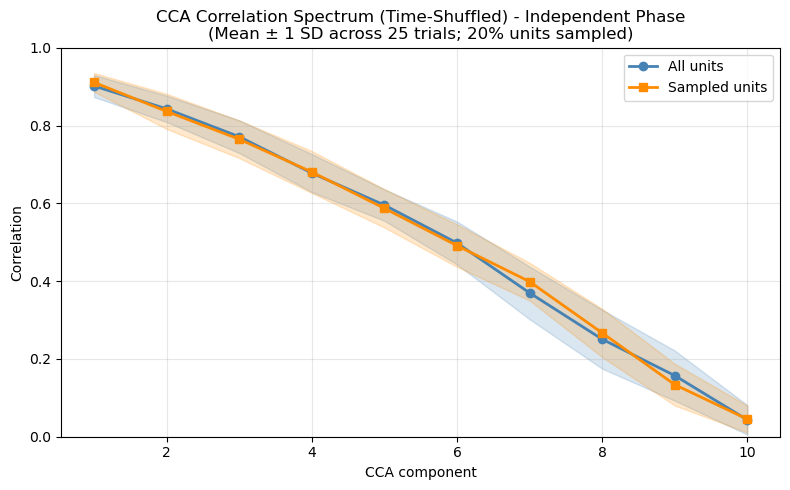

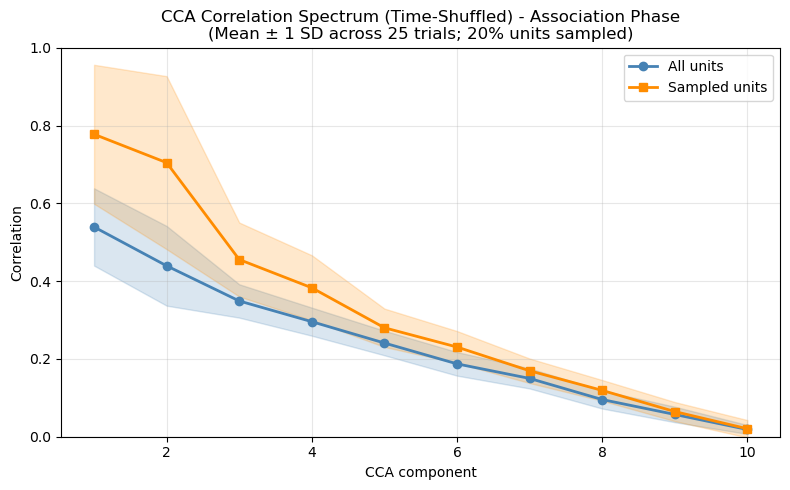

In [4]:
def plot_cca_spectra(
    cca_results: list[dict],
    phases: tuple[str, ...] = ("independent", "association"),
    fraction_sampled: float = 0.2,
) -> None:
    """
    Plot mean CCA correlation spectra across trials with shaded variance bands.
    
    Shows time-shuffled correlations (control condition where B's timepoints are
    shuffled relative to A) with two lines: mean for all units and mean for
    sampled units. Shaded regions represent ±1 standard deviation across trials.
    
    Args:
        cca_results: List of trial results from analyze_trial (time-shuffled).
        phases: Tuple of phase keys to plot (e.g., "independent", "association").
        fraction_sampled: Fraction of units in the subsampled dataset (default 0.2).
    """
    phase_titles = {"independent": "Independent Phase", "association": "Association Phase"}
    
    for phase in phases:
        # Extract correlations for all and sampled units across all trials
        all_corrs = [trial[phase]["all"]["correlations"] for trial in cca_results]
        sampled_corrs = [trial[phase]["sampled"]["correlations"] for trial in cca_results]
        
        # Convert to numpy arrays for statistics
        all_corrs_array = np.array(all_corrs)
        sampled_corrs_array = np.array(sampled_corrs)
        
        # Compute mean and standard deviation
        mean_all = np.mean(all_corrs_array, axis=0)
        std_all = np.std(all_corrs_array, axis=0)
        
        mean_sampled = np.mean(sampled_corrs_array, axis=0)
        std_sampled = np.std(sampled_corrs_array, axis=0)
        
        xs = np.arange(1, len(mean_all) + 1)
        
        plt.figure(figsize=(8, 5))
        
        # Plot for all units
        plt.plot(
            xs,
            mean_all,
            marker="o",
            label="All units",
            color="steelblue",
            linewidth=2,
        )
        plt.fill_between(
            xs,
            mean_all - std_all,
            mean_all + std_all,
            color="steelblue",
            alpha=0.2,
        )
        
        # Plot for sampled units
        plt.plot(
            xs,
            mean_sampled,
            marker="s",
            label="Sampled units",
            color="darkorange",
            linewidth=2,
        )
        plt.fill_between(
            xs,
            mean_sampled - std_sampled,
            mean_sampled + std_sampled,
            color="darkorange",
            alpha=0.2,
        )
        
        plt.axhline(0, color="gray", lw=0.8, alpha=0.5)
        plt.xlabel("CCA component")
        plt.ylabel("Correlation")
        plt.ylim(0, 1)
        sample_pct = int(fraction_sampled * 100)
        plt.title(f"CCA Correlation Spectrum (Time-Shuffled) - {phase_titles.get(phase, phase)}\n(Mean ± 1 SD across {len(cca_results)} trials; {sample_pct}% units sampled)")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()


plot_cca_spectra(cca_results, phases=("independent", "association"), fraction_sampled=FRACTION)